In [32]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn import Module, Parameter
import numpy as np
import math
from IPython import display

In [33]:
def ricker(freq, length, dt, peak_time):
    """Return a Ricker wavelet with the specified central frequency.
    Args:
        freq: A float specifying the central frequency
        length: An int specifying the number of time samples
        dt: A float specifying the time sample spacing
        peak_time: A float specifying the time (in secs) of the peak amplitude
        dtype: The PyTorch datatype to use. Optional, defaults to default.
    """
    t = np.arange(0,length)*dt - peak_time
    y = (1-2*math.pi**2 * freq**2 * t**2) * np.exp(-math.pi**2 * freq**2 * t**2)
    return y

In [34]:
class RNNCell_FD(Module):
    def __init__(self, dx, dt, isrc, ir, nx, vel):
        super(RNNCell_FD, self).__init__()
        self.dx = dx
        self.ir = ir
        self.isrc = isrc
        self.nx = nx
        self.dt = dt
        kernel = [1/(dx**2), -2/(dx**2), 1/(dx**2)]
        kernel = torch.FloatTensor(kernel).unsqueeze(0).unsqueeze(0)
        vel_init = vel**2 * self.dt
        vel_init = vel_init.unsqueeze(0).unsqueeze(0)
        self.vel = Parameter(data=vel_init, requires_grad=True)
        self.weight_conv = Parameter(data=kernel, requires_grad=False)
        
        
    def forward(self, input, h_current, h_old):
        #vel = self.vel
        if vel.shape[-1] != self.nx:
            print(f'[ERROR]: velocity model length {vel.shape[-1]} != {nx}!')
            pause
        d2px = F.conv1d(h_current, self.weight_conv)
        if d2px.shape[-1] != self.nx and (self.nx - d2px.shape[-1]) % 2 == 0:
            padd = int((self.nx - d2px.shape[-1]) / 2)
            d2pxx = F.pad(d2px, (padd, padd))
            pure_d2px = d2pxx * self.vel *self.dt
        else:
            print(f'[ERROR]: Conv lenght {nx} - {d2px.shape[-1]} ={self.nx - d2px.shape[-1]} !')
            pure_d2px = d2px * self.vel * self.dt
        
        vel_value = torch.tensor(0.0, requires_grad=True)
        local_vel = torch.sqrt(self.vel[0,0,-1] / self.dt) + vel_value
        
        # h_next = d2px * self.dt**2 * vel**2 - h_old + 2 * h_current
        h_next = pure_d2px - h_old + 2 * h_current
        # source term:
        source_factor = torch.zeros(1,1,self.nx, requires_grad=True)
        source_factor_deta = source_factor.detach()
        source_factor_deta[0,0,self.isrc] = input * self.dt**2 * 1 / self.dx * self.vel[0,0,self.isrc]**2
        h_next_plus_sr = h_next + source_factor
        
        # h_next[0,0,self.isrc] = h_next[0,0,self.isrc] + input * self.dt**2 * 1 / self.dx
        
        # bound
        value = h_next_plus_sr[0,0,-2] - 1/local_vel * (h_next_plus_sr[0,0,-2] - h_current[0,0,-2])*self.dx/self.dt
        ttmp = torch.zeros(1,1,self.nx, requires_grad=True)
        ttmp_deta = ttmp.detach()
        ttmp_deta[0,0,-1] = value
        tmp = torch.ones(1,1,self.nx, requires_grad=True)   # auxiliary tensor
        tmp_tmp = tmp.detach()
        tmp_tmp[0,0,-1] = 0
        h_next_plus_sr_bd = h_next_plus_sr * tmp + ttmp

        # h_next[0,0,-1] = h_next[0,0,-2] - 1/local_vel * (h_next[0,0,-2] - h_current[0,0,-2])*self.dx/self.dt
        tmp_zero = torch.ones(1,1,self.nx, requires_grad=True)
        tmp_zero_deta = tmp_zero.detach()
        tmp_zero_deta[0,0,0] = 0
        h_next_plus_sr_bd_total = h_next_plus_sr_bd * tmp_zero
        delta_r = torch.zeros(nx,1,requires_grad=True)
        delta_r_d = delta_r.detach()
        delta_r_d[self.ir,0] = 1
        record = torch.mm(h_next_plus_sr_bd_total.squeeze(0), delta_r)
        # h_next[0,0,0] = 0
        # return h_current, h_next_plus_sr
        return h_current, h_next_plus_sr_bd_total, record
#         delta_r = torch.zeros(nx,1,requires_grad=True)
#         delta_r_d = delta_r.detach()
#         delta_r_d[self.ir,0] = 1
#         record = torch.mm(h_next_plus_sr.squeeze(0), delta_r)
#         return h_current, h_next_plus_sr, record
        

In [35]:
dt = 0.001                     # delta
timeLen = 1                    # in second
nt = int(timeLen/dt)           # sample points
peak_freq = 10                  # in Hz
q0 = 1
peak_sorce_time = 1/peak_freq  #
source_amplitudes = q0 * ricker(peak_freq, nt, dt, peak_sorce_time)
src = source_amplitudes

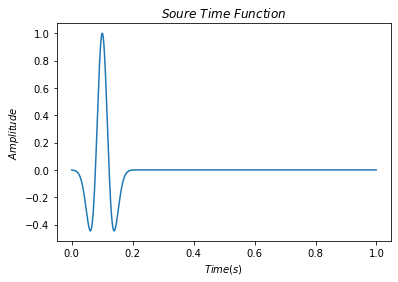

In [36]:
# plot source time function
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(np.arange(0,nt)*dt,source_amplitudes)
plt.xlabel('$Time(s)$')
plt.ylabel('$Amplitude$')
plt.title('$Soure\ Time\ Function$')
#plt.grid(ls='--')
plt.show()

torch.Size([1, 1, 200]) torch.Size([1, 1, 200])


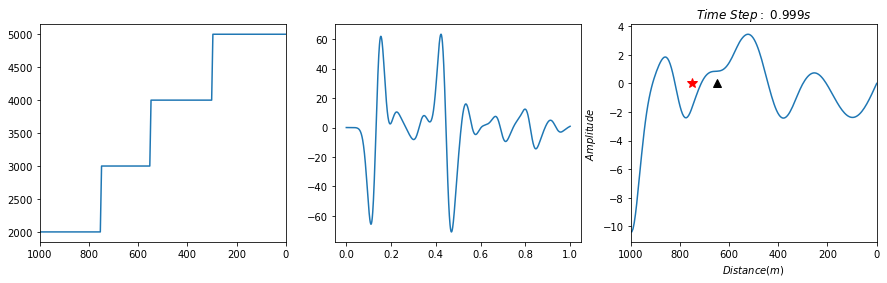

In [37]:
# 1D Wave Propagation (Finite Difference Solution)

nx   = 200         # number of grid points in x-direction
dx   = 5          # grid point distance in x-direction
isrc = 150          # source location in grid in x-direction
ir   = 130          # receiver location in grid in x-direction

h_current = torch.zeros(1,1,nx)
h_old = torch.zeros(1,1,nx)

seis = np.zeros(nt)

vel = torch.cat((torch.ones(60)*5000, torch.ones(50)*4000, torch.ones(40)*3000, torch.ones(50)*2000))
vel_test1 = torch.cat((torch.ones(40)*5000, torch.linspace(5000,4000,30), 
                       torch.ones(30)*4000, torch.linspace(4000,3000,20), 
                       torch.ones(20)*3000, torch.linspace(3000,2000,30), 
                       torch.ones(30)*2000))
#vel_test = torch.from_numpy(sm_vel_new_value)
#vel_test = sm_vel_new_value
net = RNNCell_FD(dx, dt, isrc, ir, nx, vel)
net = net.float()
check_it = -1
for it in range(nt):
    h_old, h_current, record = net(src[it], h_current, h_old)
    seis[it] = record
    if it == range(nt)[check_it]:
        print(h_old.shape, h_current.shape)
        plt.figure(figsize=(15,4))
        ax3 = plt.subplot(131)
        ax3.plot(np.linspace(0 * dx, nx * dx, nx), vel.numpy())
        ax3.set_xlim([0, nx*dx])
        ax3.invert_xaxis()
        
        ax1 = plt.subplot(132)
        time = np.linspace(0 * dt, nt * dt, nt)
        ax1.plot(time, seis)
        
        ax2 = plt.subplot(133)
        ax2.plot(np.linspace(0 * dx, nx * dx, nx), h_current[0,0,:].detach().numpy())
        ax2.plot(isrc*dx, 0, 'r*', markersize=11)
        ax2.plot(ir*dx, 0, 'k^', markersize=8)
        ax2.set_xlim([0, nx*dx])
        ax2.set_xlabel('$Distance(m)$')
        ax2.set_ylabel('$Amplitude$')
        ax2.set_title(f'$Time\ Step:\ {it*dt}s$')
        ax2.invert_xaxis()
        

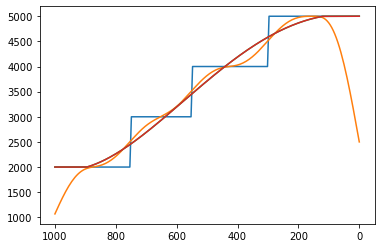

In [38]:
target = seis

N = 60
weights = np.hanning(N)

smooth_vel = np.convolve(weights/weights.sum(), vel.numpy(), 'same')
sm_vel_poly = np.polyfit(np.linspace(0 * dx, nx * dx, nx), vel.numpy(), 4)
sm_vel_value = np.polyval(sm_vel_poly, np.linspace(0 * dx, nx * dx, nx))

sm_vel_new_value = sm_vel_value
sm_vel_new_value[sm_vel_new_value>5000] = sm_vel_new_value[sm_vel_new_value>5000]*0+5000.
sm_vel_new_value[sm_vel_new_value<2000] = sm_vel_new_value[sm_vel_new_value<2000]*0+2000.

plt.figure()
ax_vel_true = plt.subplot(111)
ax_vel_true.plot(np.linspace(0 * dx, nx * dx, nx), vel.numpy())
ax_vel_true.plot(np.linspace(0 * dx, nx * dx, nx), smooth_vel)
ax_vel_true.plot(np.linspace(0 * dx, nx * dx, nx), sm_vel_value)
ax_vel_true.plot(np.linspace(0 * dx, nx * dx, nx), sm_vel_new_value)
ax_vel_true.invert_xaxis()

In [39]:
# init velocity
sm_vel_new_value = torch.from_numpy(sm_vel_new_value)

#sm_vel_value = vel
netInv = RNNCell_FD(dx, dt, isrc, ir, nx, sm_vel_new_value)
netInv = netInv.float()

h_current_Inv = torch.zeros(nt+1, 1,1,nx, requires_grad=True)
h_old_Inv = torch.zeros(nt+1, 1,1,nx, requires_grad=True)

seisInv = torch.zeros(nt, requires_grad=True)

In [40]:
optimizer = torch.optim.RMSprop(netInv.parameters(), lr=25)
loss_func = nn.MSELoss()

2/200:


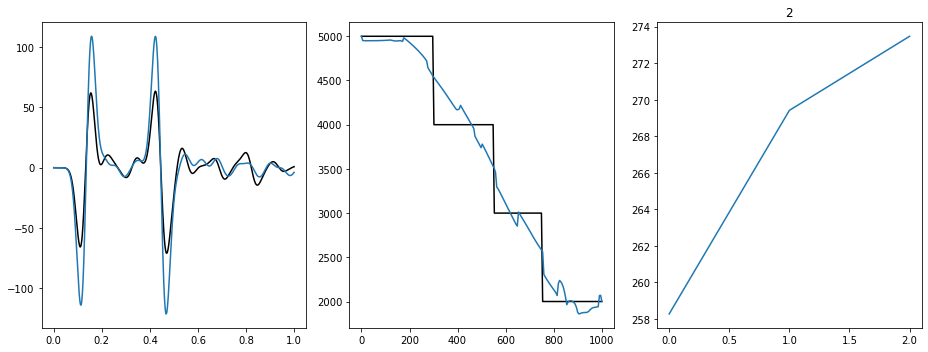

KeyboardInterrupt: 

In [41]:
from torch.autograd import Variable

target = torch.from_numpy(target).float()
total_loss = []
# with torch.autograd.set_detect_anomaly(True):
epoch = 200
for step in range(epoch):
    h_current_Inv = Variable(torch.zeros(1,1,nx))
    h_old_Inv = Variable(torch.zeros(1,1,nx))
    seisInv = Variable(torch.zeros(nt))
    print(f'{step}/{epoch}:')
    for it in range(nt):
        #print(h_current_Inv.shape, h_current_Inv[it,...].shape)
        h_old_Inv, h_current_Inv, seisInv[it] = netInv(torch.tensor(src[it]), h_current_Inv, h_old_Inv)
#             h_old_Inv[it+1,...] = h_old_Inv[it+1,...].detach()
#             h_current_Inv[it+1,...] = h_current_Inv[it+1,...].detach()
#         if it == 0:
#             total_seisInv = seisInv.unsqueeze(0)
#             total_target = torch.cat((target[:(it+1)], torch.zeros(len(target)-len(target[:it+1])))).unsqueeze(0)
#         else:
#             total_seisInv = torch.cat((total_seisInv, seisInv.unsqueeze(0)),0)
#             total_target = torch.cat((total_target, 
#                                         torch.cat((target[:(it+1)], torch.zeros(len(target)-len(target[:it+1])))).unsqueeze(0)),0)

        #total_target = torch.cat((target[:(it+1)]), torch.zeros(len(target)-len(target[:it+1])))
    loss = loss_func(seisInv, target)
    total_loss.append(loss.data)
    optimizer.zero_grad()
    loss.backward()
    #loss.backward(retain_graph=True)
    optimizer.step()

    #plt.clf() # clear axis
    plt.figure(figsize=(13,5))
    plt.ion()
    plt.subplot(131)
    seisInvClone = seisInv.clone()
    plt.plot(np.linspace(0 * dt, nt * dt, nt), target.numpy(), 'k')
    plt.plot(np.linspace(0 * dt, nt * dt, nt), seisInvClone.detach().numpy())

    plt.subplot(132)
    pama = [x for x in netInv.parameters()]
    plt.plot(np.linspace(0 * dx, nx * dx, nx), vel.numpy(), 'k')
    pamaClone = pama[0].clone()
    plt.plot(np.linspace(0 * dx, nx * dx, nx), np.sqrt(pamaClone.detach()[0,0,:].numpy()/dt))

    plt.subplot(133)
    plt.plot(total_loss)
    plt.title(f'{step}')

    plt.tight_layout()
    plt.draw()
    plt.pause(1)
    display.clear_output(wait=True)
    plt.ioff()
    plt.show()

In [22]:
a = torch.cat((torch.rand(1,1,5), torch.ones(1,1,5)), 2)
a

tensor([[[0.9805, 0.3539, 0.5406, 0.7381, 0.5943, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000]]])

In [464]:
for name, p in netInv.named_parameters():
    print(name, p)

vel Parameter containing:
tensor([[[25000.0000, 25000.0000, 25000.0000, 25000.0000, 25000.0000,
          25000.0000, 25000.0000, 25000.0000, 25000.0000, 25000.0000,
          25000.0000, 25000.0000, 25000.0000, 25000.0000, 25000.0000,
          25000.0000, 25000.0000, 25000.0000, 25000.0000, 25000.0000,
          25000.0000, 25000.0000, 25000.0000, 25000.0000, 24980.9590,
          24923.3086, 24862.2617, 24797.8359, 24730.0488, 24658.9238,
          24584.4805, 24506.7422, 24425.7344, 24341.4844, 24254.0156,
          24163.3613, 24069.5508, 23972.6152, 23872.5859, 23769.4980,
          23663.3867, 23554.2910, 23442.2461, 23327.2910, 23209.4688,
          23088.8203, 22965.3867, 22839.2129, 22710.3438, 22578.8262,
          22444.7070, 22308.0352, 22168.8594, 22027.2305, 21883.1973,
          21736.8164, 21588.1367, 21437.2148, 21284.1074, 21128.8672,
          20971.5508, 20812.2168, 20650.9238, 20487.7305, 20322.6973,
          20155.8809, 19987.3457, 19817.1523, 19645.3633, 19472.

In [41]:
for name, p in netInv.named_parameters():
    print(name, p)

vel Parameter containing:
tensor([[[25000.0020, 25000.0020, 25000.0020, 25000.0020, 25000.0020,
          25000.0020, 25000.0020, 25000.0020, 25000.0020, 25000.0020,
          25000.0020, 25000.0020, 25000.0020, 25000.0020, 25000.0020,
          25000.0020, 25000.0020, 25000.0020, 25000.0020, 25000.0020,
          25000.0020, 25000.0020, 25000.0020, 25000.0020, 25000.0020,
          25000.0020, 25000.0020, 25000.0020, 25000.0020, 25000.0020,
          25000.0020, 25000.0020, 25000.0020, 25000.0020, 25000.0020,
          25000.0020, 25000.0020, 25000.0020, 25000.0020, 25000.0020,
          25000.0020, 24656.3613, 24315.1035, 23976.2207, 23639.7148,
          23305.5918, 22973.8438, 22644.4707, 22317.4766, 21992.8633,
          21670.6309, 21350.7734, 21033.2910, 20718.1934, 20405.4688,
          20095.1230, 19787.1582, 19481.5684, 19178.3613, 18877.5293,
          18579.0723, 18282.9980, 17989.3008, 17697.9785, 17409.0371,
          17122.4746, 16838.2891, 16556.4824, 16277.0508, 16000.

In [42]:
netInv.vel.grad

tensor([[[ 0.0000e+00,  1.2597e-06,  5.0225e-06,  1.1209e-05,  1.9686e-05,
           3.0276e-05,  4.2748e-05,  5.6822e-05,  7.2171e-05,  8.8428e-05,
           1.0518e-04,  1.2198e-04,  1.3837e-04,  1.5386e-04,  1.6796e-04,
           1.8017e-04,  1.9004e-04,  1.9711e-04,  2.0100e-04,  2.0138e-04,
           1.9797e-04,  1.9062e-04,  1.7923e-04,  1.6383e-04,  1.4478e-04,
           1.2241e-04,  9.6547e-05,  6.7587e-05,  3.6046e-05,  2.5512e-06,
          -3.2161e-05, -6.7312e-05, -1.0214e-04, -1.3600e-04, -1.6827e-04,
          -1.9037e-04, -2.1621e-04, -2.3847e-04, -2.5650e-04, -2.6980e-04,
          -2.7795e-04, -2.8071e-04, -2.7792e-04, -2.6961e-04, -2.5591e-04,
          -2.3712e-04, -2.1365e-04, -1.8605e-04, -1.5497e-04, -1.2114e-04,
          -8.5371e-05, -4.8499e-05, -1.1400e-05,  2.5051e-05,  6.0056e-05,
           9.7297e-05,  1.2932e-04,  1.5850e-04,  1.8390e-04,  2.0477e-04,
           2.2088e-04,  2.3221e-04,  2.3887e-04,  2.4114e-04,  2.3936e-04,
           2.3400e-04,  2

In [13]:
F.conv1d(torch.rand(1,1,10), torch.rand(1,1,3)).squeeze(0).squeeze(0)

tensor([1.3070, 0.9897, 1.4262, 0.9293, 1.0681, 0.5637, 0.4808, 0.8218])

In [43]:
a = [x for x in net.parameters()]
a[0].detach()[0,0,:].numpy()

array([25000.002 , 25000.002 , 25000.002 , 25000.002 , 25000.002 ,
       25000.002 , 25000.002 , 25000.002 , 25000.002 , 25000.002 ,
       25000.002 , 25000.002 , 25000.002 , 25000.002 , 25000.002 ,
       25000.002 , 25000.002 , 25000.002 , 25000.002 , 25000.002 ,
       25000.002 , 25000.002 , 25000.002 , 25000.002 , 25000.002 ,
       25000.002 , 25000.002 , 25000.002 , 25000.002 , 25000.002 ,
       25000.002 , 25000.002 , 25000.002 , 25000.002 , 25000.002 ,
       25000.002 , 25000.002 , 25000.002 , 25000.002 , 25000.002 ,
       25000.002 , 25000.002 , 25000.002 , 25000.002 , 25000.002 ,
       25000.002 , 25000.002 , 25000.002 , 25000.002 , 25000.002 ,
       25000.002 , 25000.002 , 25000.002 , 25000.002 , 25000.002 ,
       25000.002 , 25000.002 , 25000.002 , 25000.002 , 25000.002 ,
       16000.001 , 16000.001 , 16000.001 , 16000.001 , 16000.001 ,
       16000.001 , 16000.001 , 16000.001 , 16000.001 , 16000.001 ,
       16000.001 , 16000.001 , 16000.001 , 16000.001 , 16000.0

In [22]:
padd = torch.ones(5)
padd

tensor([1., 1., 1., 1., 1.])

In [23]:
F.pad(padd, (1,1))

tensor([0., 1., 1., 1., 1., 1., 0.])

In [87]:
a = torch.randn(1,1,4, requires_grad=True)
print(a.shape)
#b = a.sequeeze(0)
b = a.squeeze(0).squeeze(0)

torch.Size([1, 1, 4])


In [153]:
a = torch.randn(2,1,1,3)
a

tensor([[[[ 0.9240,  1.4451, -2.0026]]],


        [[[-0.8470, -0.6673,  0.0417]]]])

In [218]:
a.requires_grad = True

In [219]:
a[1,...].requires_grad

True

In [159]:
torch.cat((a,torch.zeros(2,3)), 0)

tensor([[-1.0054,  1.2155,  0.4531],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [391]:
torch.sqrt(torch.tensor(25.0))

tensor(5.)

In [48]:
a = torch.zeros(5, requires_grad=True)
a

tensor([0., 0., 0., 0., 0.], requires_grad=True)

In [50]:
a[0] = 1

In [52]:
a[0]

tensor(1., grad_fn=<SelectBackward>)